In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.6 MB 212 kB/s 
     |████████████████████████████████| 190 kB 5.0 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7187, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 7187 (delta 50), reused 160 (delta 38), pack-reused 6995
Receiving objects: 100% (7187/7187), 13.43 MiB | 47.24 MiB/s, done.
Resolving deltas: 100% (5243/5243), done.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

--2022-05-26 01:39:12--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  8.36MB/s    in 41s     

2022-05-26 01:39:53 (7.73 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building','Boundary')
palette = [[0, 0, 0], [255, 0, 0], [0, 0, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.device='cuda'

cfg.model.decode_head.num_classes = 3

#cfg.data.samples_per_gpu=2
#cfg.data.workers_per_gpu=2

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]


In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/contour_ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='DiceLoss', loss_weight=1.0),
            dict(type='FocalLoss', loss_

### 모델 학습

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-26 01:39:56,059 - mmseg - INFO - Loaded 537 images
2022-05-26 01:40:10,936 - mmseg - INFO - Loaded 113 images
2022-05-26 01:40:10,939 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-26 01:40:11,372 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
2022-05-26 01:40:11,378 - mmseg - INFO - Start running, host: root@409dc52e165e, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz
2022-05-26 01:40:11,379 - mmseg - INFO - Hooks will be executed in the following o

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 451s, ETA:     0s

2022-05-26 01:54:34,901 - mmseg - INFO - per class results:
2022-05-26 01:54:34,903 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.31 | 89.15 |
|  building  | 71.49 | 87.51 |
|  Boundary  | 44.05 | 64.44 |
+------------+-------+-------+
2022-05-26 01:54:34,905 - mmseg - INFO - Summary:
2022-05-26 01:54:34,907 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 85.3 | 66.95 | 80.37 |
+------+-------+-------+
2022-05-26 01:54:34,909 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8530, mIoU: 0.6695, mAcc: 0.8037, IoU.background: 0.8531, IoU.building: 0.7149, IoU.Boundary: 0.4405, Acc.background: 0.8915, Acc.building: 0.8751, Acc.Boundary: 0.6444
2022-05-26 01:55:08,832 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 4:16:58, time: 4.850, data_time: 4.537, memory: 3323, decode.loss_dice: 0.2169, decode.loss_focal: 0.0493, decode.loss_lovasz: 0.3906, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 02:07:13,372 - mmseg - INFO - per class results:
2022-05-26 02:07:13,374 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.65 | 93.26 |
|  building  | 75.55 | 87.88 |
|  Boundary  | 48.67 | 65.32 |
+------------+-------+-------+
2022-05-26 02:07:13,376 - mmseg - INFO - Summary:
2022-05-26 02:07:13,382 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.04 | 70.96 | 82.15 |
+-------+-------+-------+
2022-05-26 02:07:13,383 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8804, mIoU: 0.7096, mAcc: 0.8215, IoU.background: 0.8865, IoU.building: 0.7555, IoU.Boundary: 0.4867, Acc.background: 0.9326, Acc.building: 0.8788, Acc.Boundary: 0.6532
2022-05-26 02:07:45,034 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 3:54:54, time: 4.610, data_time: 4.299, memory: 3323, decode.loss_dice: 0.1866, decode.loss_focal: 0.0446, decode.loss_lovasz: 0.3540, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 02:19:48,967 - mmseg - INFO - per class results:
2022-05-26 02:19:48,969 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  86.6 | 89.21 |
|  building  | 74.29 | 90.45 |
|  Boundary  | 46.63 | 67.77 |
+------------+-------+-------+
2022-05-26 02:19:48,970 - mmseg - INFO - Summary:
2022-05-26 02:19:48,972 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.51 | 69.17 | 82.48 |
+-------+-------+-------+
2022-05-26 02:19:48,975 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8651, mIoU: 0.6917, mAcc: 0.8248, IoU.background: 0.8660, IoU.building: 0.7429, IoU.Boundary: 0.4663, Acc.background: 0.8921, Acc.building: 0.9045, Acc.Boundary: 0.6777
2022-05-26 02:20:20,639 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 3:38:53, time: 4.608, data_time: 4.296, memory: 3323, decode.loss_dice: 0.1702, decode.loss_focal: 0.0410, decode.loss_lovasz: 0.3354, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 02:32:24,603 - mmseg - INFO - per class results:
2022-05-26 02:32:24,605 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.26 | 93.87 |
|  building  | 76.37 | 84.58 |
|  Boundary  | 51.77 | 72.45 |
+------------+-------+-------+
2022-05-26 02:32:24,607 - mmseg - INFO - Summary:
2022-05-26 02:32:24,611 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.62 | 72.47 | 83.63 |
+-------+-------+-------+
2022-05-26 02:32:24,613 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8862, mIoU: 0.7247, mAcc: 0.8363, IoU.background: 0.8926, IoU.building: 0.7637, IoU.Boundary: 0.5177, Acc.background: 0.9387, Acc.building: 0.8458, Acc.Boundary: 0.7245
2022-05-26 02:32:56,621 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 3:24:34, time: 4.614, data_time: 4.299, memory: 3323, decode.loss_dice: 0.1450, decode.loss_focal: 0.0374, decode.loss_lovasz: 0.2988, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-26 02:45:02,631 - mmseg - INFO - per class results:
2022-05-26 02:45:02,633 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.61 | 94.57 |
|  building  | 77.16 | 89.36 |
|  Boundary  | 49.43 | 63.02 |
+------------+-------+-------+
2022-05-26 02:45:02,635 - mmseg - INFO - Summary:
2022-05-26 02:45:02,637 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.89 | 72.06 | 82.32 |
+-------+-------+-------+
2022-05-26 02:45:02,639 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8889, mIoU: 0.7206, mAcc: 0.8232, IoU.background: 0.8961, IoU.building: 0.7716, IoU.Boundary: 0.4943, Acc.background: 0.9457, Acc.building: 0.8936, Acc.Boundary: 0.6302
2022-05-26 02:45:34,225 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 3:11:00, time: 4.625, data_time: 4.314, memory: 3323, decode.loss_dice: 0.1549, decode.loss_focal: 0.0368, decode.loss_lovasz: 0.3116, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-26 02:57:38,992 - mmseg - INFO - per class results:
2022-05-26 02:57:38,994 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.39 | 93.04 |
|  building  | 77.41 | 88.85 |
|  Boundary  | 51.58 | 70.22 |
+------------+-------+-------+
2022-05-26 02:57:38,996 - mmseg - INFO - Summary:
2022-05-26 02:57:38,998 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.83 | 72.79 | 84.04 |
+-------+-------+-------+
2022-05-26 02:57:39,004 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8883, mIoU: 0.7279, mAcc: 0.8404, IoU.background: 0.8939, IoU.building: 0.7741, IoU.Boundary: 0.5158, Acc.background: 0.9304, Acc.building: 0.8885, Acc.Boundary: 0.7022
2022-05-26 02:58:10,612 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 2:57:42, time: 4.625, data_time: 4.315, memory: 3323, decode.loss_dice: 0.1512, decode.loss_focal: 0.0364, decode.loss_lovasz: 0.3029, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 03:10:13,245 - mmseg - INFO - per class results:
2022-05-26 03:10:13,247 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.18 | 94.96 |
|  building  | 76.94 | 84.87 |
|  Boundary  | 52.19 | 71.06 |
+------------+-------+-------+
2022-05-26 03:10:13,250 - mmseg - INFO - Summary:
2022-05-26 03:10:13,251 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.17 | 73.1 | 83.63 |
+-------+------+-------+
2022-05-26 03:10:13,255 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8917, mIoU: 0.7310, mAcc: 0.8363, IoU.background: 0.9018, IoU.building: 0.7694, IoU.Boundary: 0.5219, Acc.background: 0.9496, Acc.building: 0.8487, Acc.Boundary: 0.7106
2022-05-26 03:10:44,896 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 2:44:31, time: 4.609, data_time: 4.298, memory: 3323, decode.loss_dice: 0.1443, decode.loss_focal: 0.0342, decode.loss_lovasz: 0.2931, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 03:22:46,080 - mmseg - INFO - per class results:
2022-05-26 03:22:46,082 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.85 | 94.12 |
|  building  | 77.91 | 88.23 |
|  Boundary  | 52.48 | 69.67 |
+------------+-------+-------+
2022-05-26 03:22:46,085 - mmseg - INFO - Summary:
2022-05-26 03:22:46,087 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.27 | 73.41 | 84.01 |
+-------+-------+-------+
2022-05-26 03:22:46,090 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8927, mIoU: 0.7341, mAcc: 0.8401, IoU.background: 0.8985, IoU.building: 0.7791, IoU.Boundary: 0.5248, Acc.background: 0.9412, Acc.building: 0.8823, Acc.Boundary: 0.6967
2022-05-26 03:23:19,902 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:31:31, time: 4.631, data_time: 4.319, memory: 3323, decode.loss_dice: 0.1468, decode.loss_focal: 0.0350, decode.loss_lovasz: 0.3011, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 03:35:23,344 - mmseg - INFO - per class results:
2022-05-26 03:35:23,346 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.09 | 94.43 |
|  building  | 78.15 | 89.57 |
|  Boundary  |  51.9 | 66.98 |
+------------+-------+-------+
2022-05-26 03:35:23,349 - mmseg - INFO - Summary:
2022-05-26 03:35:23,352 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.41 | 73.38 | 83.66 |
+-------+-------+-------+
2022-05-26 03:35:23,356 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8941, mIoU: 0.7338, mAcc: 0.8366, IoU.background: 0.9009, IoU.building: 0.7815, IoU.Boundary: 0.5190, Acc.background: 0.9443, Acc.building: 0.8957, Acc.Boundary: 0.6698
2022-05-26 03:35:54,865 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:18:36, time: 4.607, data_time: 4.297, memory: 3323, decode.loss_dice: 0.1458, decode.loss_focal: 0.0344, decode.loss_lovasz: 0.2956, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 03:47:58,502 - mmseg - INFO - per class results:
2022-05-26 03:47:58,504 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.26 | 95.18 |
|  building  | 78.28 | 87.51 |
|  Boundary  | 52.56 | 68.35 |
+------------+-------+-------+
2022-05-26 03:47:58,505 - mmseg - INFO - Summary:
2022-05-26 03:47:58,507 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.57 | 73.7 | 83.68 |
+-------+------+-------+
2022-05-26 03:47:58,509 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8957, mIoU: 0.7370, mAcc: 0.8368, IoU.background: 0.9026, IoU.building: 0.7828, IoU.Boundary: 0.5256, Acc.background: 0.9518, Acc.building: 0.8751, Acc.Boundary: 0.6835
2022-05-26 03:48:30,305 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 2:05:46, time: 4.609, data_time: 4.297, memory: 3323, decode.loss_dice: 0.1386, decode.loss_focal: 0.0347, decode.loss_lovasz: 0.2867, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 04:00:33,935 - mmseg - INFO - per class results:
2022-05-26 04:00:33,937 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.16 | 93.49 |
|  building  | 78.69 | 89.59 |
|  Boundary  | 53.33 | 71.83 |
+------------+-------+-------+
2022-05-26 04:00:33,940 - mmseg - INFO - Summary:
2022-05-26 04:00:33,943 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.51 | 74.06 | 84.97 |
+-------+-------+-------+
2022-05-26 04:00:33,945 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8951, mIoU: 0.7406, mAcc: 0.8497, IoU.background: 0.9016, IoU.building: 0.7869, IoU.Boundary: 0.5333, Acc.background: 0.9349, Acc.building: 0.8959, Acc.Boundary: 0.7183
2022-05-26 04:01:05,617 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 1:52:58, time: 4.610, data_time: 4.298, memory: 3323, decode.loss_dice: 0.1400, decode.loss_focal: 0.0333, decode.loss_lovasz: 0.2882, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 04:13:09,790 - mmseg - INFO - per class results:
2022-05-26 04:13:09,792 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.71 | 95.55 |
|  building  | 76.99 |  84.1 |
|  Boundary  | 52.85 | 70.02 |
+------------+-------+-------+
2022-05-26 04:13:09,793 - mmseg - INFO - Summary:
2022-05-26 04:13:09,796 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 89.2 | 73.18 | 83.22 |
+------+-------+-------+
2022-05-26 04:13:09,800 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8920, mIoU: 0.7318, mAcc: 0.8322, IoU.background: 0.8971, IoU.building: 0.7699, IoU.Boundary: 0.5285, Acc.background: 0.9555, Acc.building: 0.8410, Acc.Boundary: 0.7002
2022-05-26 04:13:41,381 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:40:13, time: 4.608, data_time: 4.297, memory: 3323, decode.loss_dice: 0.1331, decode.loss_focal: 0.0334, decode.loss_lovasz: 0.2764, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 04:25:46,204 - mmseg - INFO - per class results:
2022-05-26 04:25:46,207 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.35 | 94.08 |
|  building  | 78.56 | 89.88 |
|  Boundary  | 52.31 | 68.86 |
+------------+-------+-------+
2022-05-26 04:25:46,208 - mmseg - INFO - Summary:
2022-05-26 04:25:46,210 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.53 | 73.74 | 84.27 |
+-------+-------+-------+
2022-05-26 04:25:46,216 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8953, mIoU: 0.7374, mAcc: 0.8427, IoU.background: 0.9035, IoU.building: 0.7856, IoU.Boundary: 0.5231, Acc.background: 0.9408, Acc.building: 0.8988, Acc.Boundary: 0.6886
2022-05-26 04:26:17,870 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:27:29, time: 4.609, data_time: 4.298, memory: 3323, decode.loss_dice: 0.1300, decode.loss_focal: 0.0312, decode.loss_lovasz: 0.2719, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 04:38:23,010 - mmseg - INFO - per class results:
2022-05-26 04:38:23,012 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.44 | 93.89 |
|  building  | 79.04 | 88.97 |
|  Boundary  | 53.81 | 72.58 |
+------------+-------+-------+
2022-05-26 04:38:23,015 - mmseg - INFO - Summary:
2022-05-26 04:38:23,016 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.71 | 74.43 | 85.15 |
+-------+-------+-------+
2022-05-26 04:38:23,019 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8971, mIoU: 0.7443, mAcc: 0.8515, IoU.background: 0.9044, IoU.building: 0.7904, IoU.Boundary: 0.5381, Acc.background: 0.9389, Acc.building: 0.8897, Acc.Boundary: 0.7258
2022-05-26 04:38:54,724 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:14:47, time: 4.612, data_time: 4.300, memory: 3323, decode.loss_dice: 0.1281, decode.loss_focal: 0.0316, decode.loss_lovasz: 0.2714, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 04:50:57,089 - mmseg - INFO - per class results:
2022-05-26 04:50:57,091 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.64 | 94.95 |
|  building  | 78.98 | 87.65 |
|  Boundary  | 53.81 | 71.25 |
+------------+-------+-------+
2022-05-26 04:50:57,096 - mmseg - INFO - Summary:
2022-05-26 04:50:57,098 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.86 | 74.47 | 84.61 |
+-------+-------+-------+
2022-05-26 04:50:57,100 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8986, mIoU: 0.7447, mAcc: 0.8461, IoU.background: 0.9064, IoU.building: 0.7898, IoU.Boundary: 0.5381, Acc.background: 0.9495, Acc.building: 0.8765, Acc.Boundary: 0.7125
2022-05-26 04:51:31,012 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:02:05, time: 4.633, data_time: 4.320, memory: 3323, decode.loss_dice: 0.1313, decode.loss_focal: 0.0341, decode.loss_lovasz: 0.2736, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 05:03:34,433 - mmseg - INFO - per class results:
2022-05-26 05:03:34,435 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.68 |  94.4 |
|  building  | 79.37 | 88.91 |
|  Boundary  | 54.01 |  71.9 |
+------------+-------+-------+
2022-05-26 05:03:34,436 - mmseg - INFO - Summary:
2022-05-26 05:03:34,438 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.92 | 74.69 | 85.07 |
+-------+-------+-------+
2022-05-26 05:03:34,444 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8992, mIoU: 0.7469, mAcc: 0.8507, IoU.background: 0.9068, IoU.building: 0.7937, IoU.Boundary: 0.5401, Acc.background: 0.9440, Acc.building: 0.8891, Acc.Boundary: 0.7190
2022-05-26 05:04:06,070 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:49:23, time: 4.611, data_time: 4.301, memory: 3323, decode.loss_dice: 0.1229, decode.loss_focal: 0.0300, decode.loss_lovasz: 0.2631, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 05:16:11,572 - mmseg - INFO - per class results:
2022-05-26 05:16:11,573 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.99 | 95.38 |
|  building  | 79.46 | 88.65 |
|  Boundary  | 53.99 | 69.69 |
+------------+-------+-------+
2022-05-26 05:16:11,577 - mmseg - INFO - Summary:
2022-05-26 05:16:11,578 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.15 | 74.81 | 84.57 |
+-------+-------+-------+
2022-05-26 05:16:11,582 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9015, mIoU: 0.7481, mAcc: 0.8457, IoU.background: 0.9099, IoU.building: 0.7946, IoU.Boundary: 0.5399, Acc.background: 0.9538, Acc.building: 0.8865, Acc.Boundary: 0.6969
2022-05-26 05:16:43,384 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:36:43, time: 4.612, data_time: 4.299, memory: 3323, decode.loss_dice: 0.1240, decode.loss_focal: 0.0316, decode.loss_lovasz: 0.2626, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 05:28:47,710 - mmseg - INFO - per class results:
2022-05-26 05:28:47,713 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.83 | 94.57 |
|  building  | 79.27 | 88.23 |
|  Boundary  | 54.52 | 72.88 |
+------------+-------+-------+
2022-05-26 05:28:47,715 - mmseg - INFO - Summary:
2022-05-26 05:28:47,718 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 90.0 | 74.87 | 85.23 |
+------+-------+-------+
2022-05-26 05:28:47,720 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9000, mIoU: 0.7487, mAcc: 0.8523, IoU.background: 0.9083, IoU.building: 0.7927, IoU.Boundary: 0.5452, Acc.background: 0.9457, Acc.building: 0.8823, Acc.Boundary: 0.7288
2022-05-26 05:29:19,295 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:24:03, time: 4.610, data_time: 4.299, memory: 3323, decode.loss_dice: 0.1202, decode.loss_focal: 0.0285, decode.loss_lovasz: 0.2529, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 05:41:21,958 - mmseg - INFO - per class results:
2022-05-26 05:41:21,960 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.9 | 94.98 |
|  building  | 79.47 | 88.62 |
|  Boundary  | 54.25 | 71.06 |
+------------+-------+-------+
2022-05-26 05:41:21,963 - mmseg - INFO - Summary:
2022-05-26 05:41:21,965 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.09 | 74.87 | 84.89 |
+-------+-------+-------+
2022-05-26 05:41:21,968 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9009, mIoU: 0.7487, mAcc: 0.8489, IoU.background: 0.9090, IoU.building: 0.7947, IoU.Boundary: 0.5425, Acc.background: 0.9498, Acc.building: 0.8862, Acc.Boundary: 0.7106
2022-05-26 05:41:53,578 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:11:23, time: 4.608, data_time: 4.297, memory: 3323, decode.loss_dice: 0.1203, decode.loss_focal: 0.0319, decode.loss_lovasz: 0.2571, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-26 05:53:56,368 - mmseg - INFO - per class results:
2022-05-26 05:53:56,370 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.8 | 94.66 |
|  building  | 79.42 | 87.92 |
|  Boundary  | 54.58 | 73.15 |
+------------+-------+-------+
2022-05-26 05:53:56,375 - mmseg - INFO - Summary:
2022-05-26 05:53:56,376 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.01 | 74.93 | 85.24 |
+-------+-------+-------+
2022-05-26 05:53:56,378 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9001, mIoU: 0.7493, mAcc: 0.8524, IoU.background: 0.9080, IoU.building: 0.7942, IoU.Boundary: 0.5458, Acc.background: 0.9466, Acc.building: 0.8792, Acc.Boundary: 0.7315


### 모델 결과 시각화

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


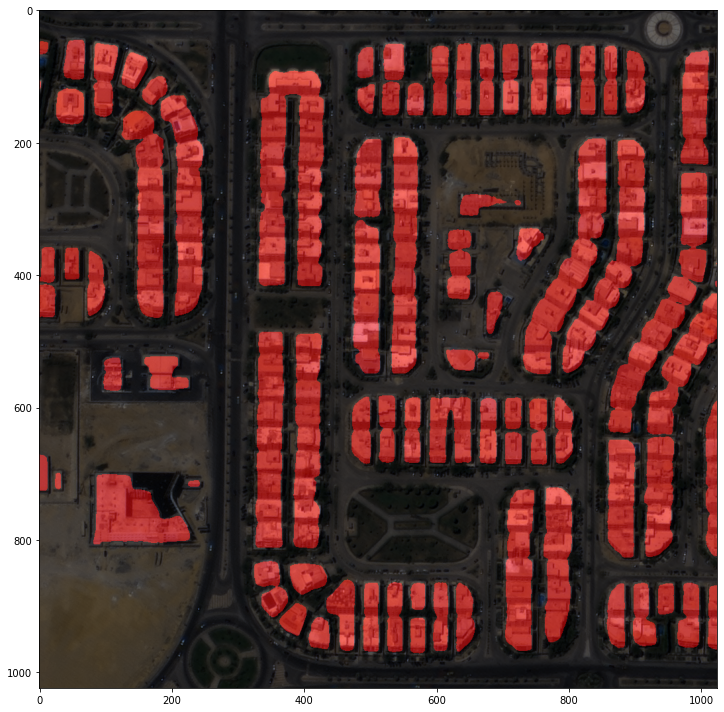

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


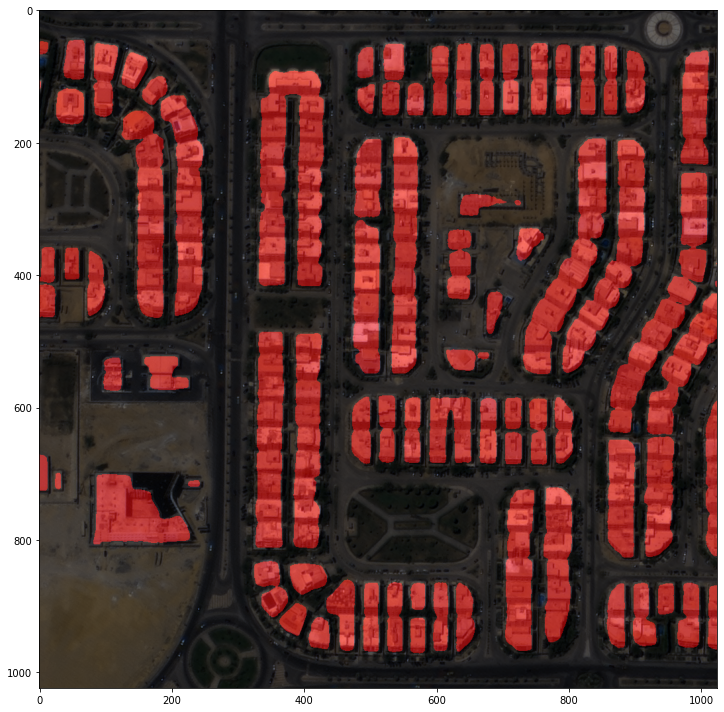

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


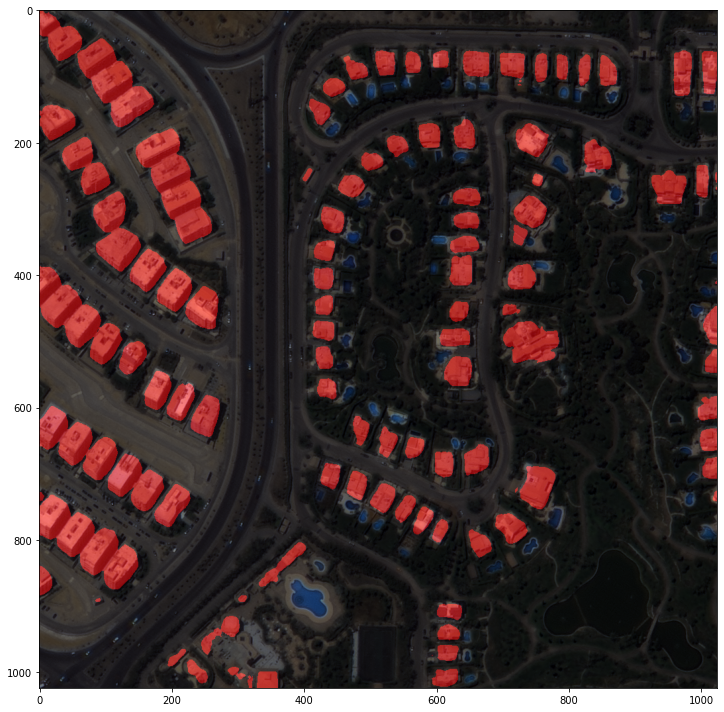

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


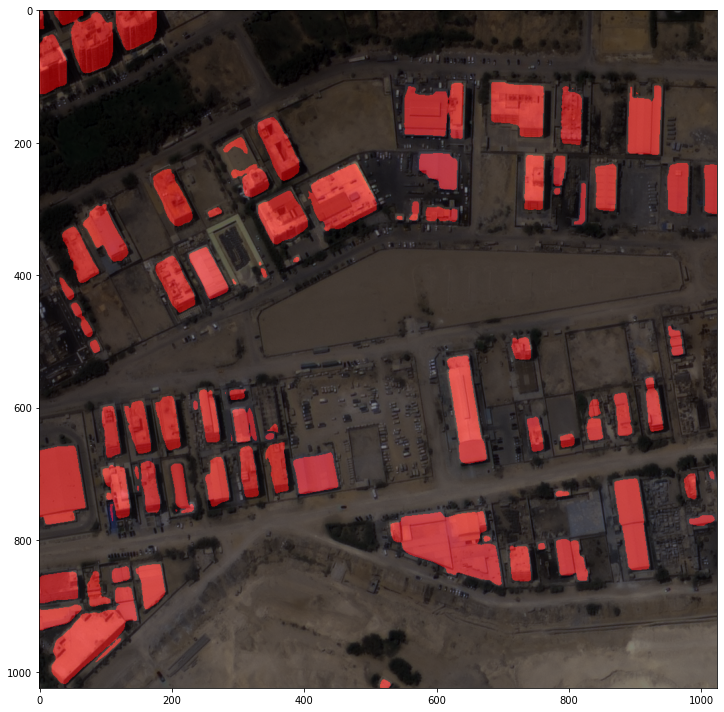

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

#### 네이버 지도 이미지로 테스트

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


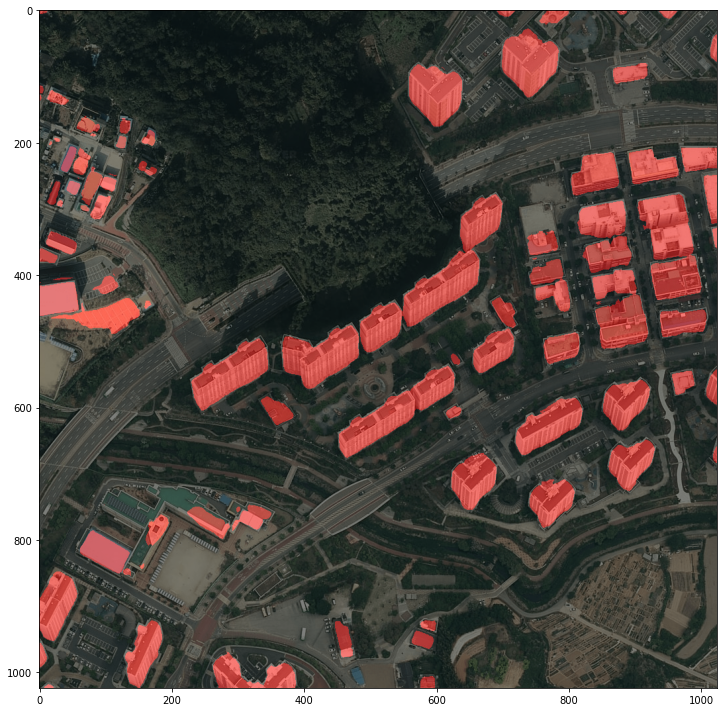

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


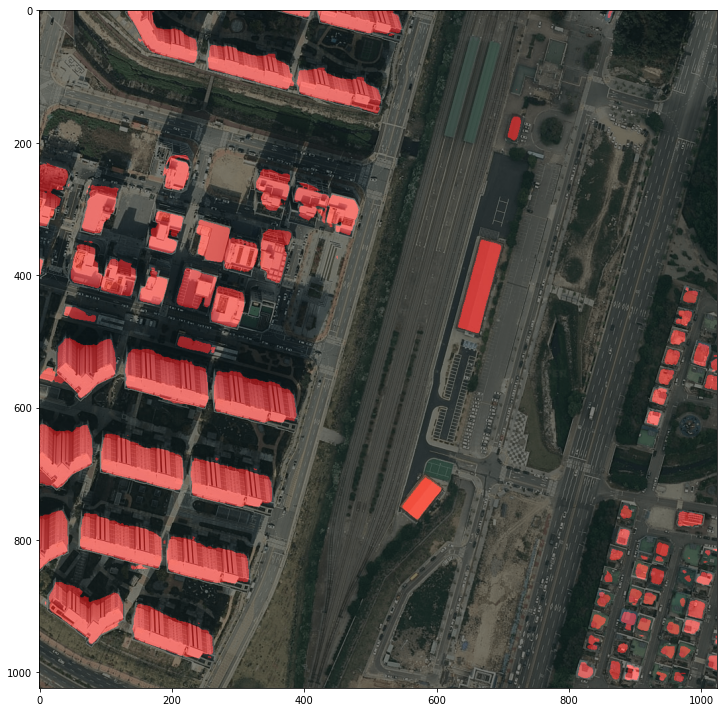

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


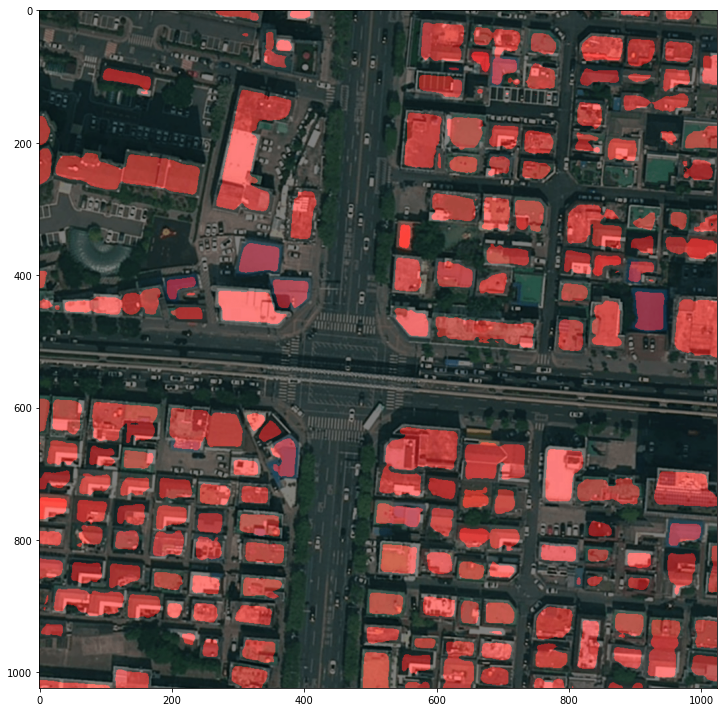

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)